In [ ]:
import json
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import random
from collections import defaultdict

import numpy as np
import glob
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, IterableDataset
from typing import List, Dict
from itertools import chain

data_dir = Path('/kaggle/input/')
output_dir = Path('/kaggle/working/')

nltk.download('stopwords', download_dir=output_dir)
nltk.download('wordnet', download_dir=output_dir)
!unzip -o /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora/

nltk.data.path.append(output_dir)
stopwords = set(stopwords.words('english'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

[nltk_data] Downloading package stopwords to /kaggle/working...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /kaggle/working...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  

device(type='cpu')

## **Task-1**. Use the COVID-19 corpus
Extract all the abstracts from the COVID-19 text files and use them as the corpus. Ensure that you create
a vocabulary of around 10,000 words

In [ ]:
abstracts = []
json_files = glob.glob(f"{data_dir}/pdf_json/pdf_json/*json")
lemmatizer = WordNetLemmatizer()

for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
    abstract_ = []
    for abstract in data['abstract']:
        abstract = re.sub(r'[^a-z\s]', '', abstract['text'].strip().lower())
        for word in abstract.split():
            word = lemmatizer.lemmatize(word)
            if word not in stopwords and word != '':
                abstract_.append(word)
        abstracts.append(abstract_)

c = Counter([w for abstract in abstracts for w in abstract])

# Removing any word with the length less than 2
vocab_counter = Counter({w:v for w, v in c.items() if len(w) > 2})

# Taking most common 10000 words
vocab = set(w[0] for w in vocab_counter.most_common(10000))
print(f"Length of the vocabulary: {len(vocab)}")

Length of the vocabulary: 10000


In [ ]:
# Creating the corpus with most common 10000 words
abstracts = [[w for w in abstract if w in vocab] for abstract in abstracts]

In [ ]:
class SkipGramDataset(IterableDataset):
    def __init__(self,
                 documents: List[List[str]],
                 window_size: int = 2,
                 num_negative: int = 5,
                 min_count: int = 5,
                 sampling_table_size: int = 1e8):
        """
        Args:
            documents: List of documents, where each document is a list of words
            window_size: Maximum distance between target and context words
            num_negative: Number of negative samples per positive pair
            min_count: Minimum frequency of words to include in vocab
            sampling_table_size: Size of the negative sampling table
        """
        super().__init__()
        self.documents = documents
        self.window_size = window_size
        self.num_negative = num_negative

        # Build vocabulary and frequency table
        print("Building vocabulary...")
        self.vocab, self.word_freqs = self._build_vocab(min_count)
        self.vocab_size = len(self.vocab)

        # Create negative sampling table
        print("Creating negative sampling table...")
        self.negative_table = self._create_negative_table(int(sampling_table_size))

        # Pre-calculate document lengths and cumulative lengths for efficient indexing
        self.doc_lengths = [len(doc) for doc in documents]
        self.cumsum_lengths = np.cumsum(self.doc_lengths)
        self.total_words = self.cumsum_lengths[-1]

        # Calculate approximate number of pairs for length estimation
        words_per_window = window_size * 2
        self.approx_pairs = self.total_words * words_per_window

    def _build_vocab(self, min_count):
        """Build vocabulary and compute normalized word frequencies"""
        # Count words
        word_counts = Counter(chain.from_iterable(self.documents))

        # Filter by minimum count and create vocabulary
        filtered_words = [(word, count) for word, count in word_counts.items()
                         if count >= min_count]
        vocab = {word: idx for idx, (word, _) in enumerate(filtered_words)}

        # Compute normalized frequencies for negative sampling
        freqs = np.array([count for _, count in filtered_words], dtype=np.float32)
        freqs = np.power(freqs, 0.75)
        freqs = freqs / freqs.sum()

        return vocab, freqs

    def _create_negative_table(self, size):
        """Create table for efficient negative sampling"""
        table = np.zeros(size, dtype=np.int32)
        p = 0
        i = 0

        # Fill table according to word frequencies
        for word_idx, freq in enumerate(self.word_freqs):
            p += freq
            while i < size and i / size < p:
                table[i] = word_idx
                i += 1

        return table

    def _get_negative_samples(self, pos_id, context_id):
        """Get negative samples, excluding positive examples"""
        samples = []
        while len(samples) < self.num_negative:
            neg_id = self.negative_table[random.randint(0, len(self.negative_table) - 1)]
            if neg_id != pos_id and neg_id != context_id:
                samples.append(neg_id)
        return samples

    def _get_doc_and_pos(self, index):
        """Get document and word position from global index"""
        doc_idx = np.searchsorted(self.cumsum_lengths, index, side='right')
        if doc_idx == 0:
            pos = index
        else:
            pos = index - self.cumsum_lengths[doc_idx - 1]
        return self.documents[doc_idx], pos

    def __iter__(self):
        """Generate pairs on-the-fly"""
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # Single-process data loading
            start_idx = 0
            end_idx = self.total_words
        else:
            # Multi-process data loading
            per_worker = int(np.ceil(self.total_words / worker_info.num_workers))
            worker_id = worker_info.id
            start_idx = worker_id * per_worker
            end_idx = min(start_idx + per_worker, self.total_words)

        # Generate pairs for this worker's range
        for idx in range(start_idx, end_idx):
            document, pos = self._get_doc_and_pos(idx)

            # Skip if word not in vocabulary
            if document[pos] not in self.vocab:
                continue

            target_id = self.vocab[document[pos]]

            # Generate context words within window
            window_start = max(0, pos - self.window_size)
            window_end = min(len(document), pos + self.window_size + 1)

            for context_pos in range(window_start, window_end):
                if context_pos != pos and document[context_pos] in self.vocab:
                    context_id = self.vocab[document[context_pos]]
                    neg_samples = self._get_negative_samples(target_id, context_id)

                    yield (
                        torch.tensor(target_id, dtype=torch.long),
                        torch.tensor(context_id, dtype=torch.long),
                        torch.tensor(neg_samples, dtype=torch.long)
                    )

    def __len__(self):
        """Approximate length for progress bars"""
        return self.approx_pairs

In [ ]:
# Creating dataloader
batch_size = 1024
window_size = 2
num_negative = 5
min_count = 5
num_workers = 4

dataset = SkipGramDataset(
    documents=abstracts,
    window_size=window_size,
    num_negative=num_negative,
    min_count=min_count
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    collate_fn=lambda batch: (
        torch.stack([item[0] for item in batch]),
        torch.stack([item[1] for item in batch]),
        torch.stack([item[2] for item in batch])
    )
)

Building vocabulary...
Creating negative sampling table...


## **Task-3** Description of the model

Skip-gram model with negative sampling, used for word embedding learning.

**1. Architecture:**
- Uses one embedding matrice for target words and one linear layer for context predictions
- Implements negative sampling to improve training efficiency.

**2. Main Components:**
- `target_embeddings`: Embedding layer for target words
- `context_linear`: Linear layer for predicting context words
- Both layers are initialized with uniform random weights in [-0.1, 0.1]

**3. Forward Pass:**
- Takes target words, context words, and negative samples as input
- Calculates positive scores for true context words
- Calculates negative scores for randomly sampled negative words
- Combines both into a negative sampling loss function

The model is designed for efficient training on large text corpora to learn word representations that capture semantic relationships between words.

In [ ]:
class SkipGramHybrid(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        # Embedding layer for target words
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Linear layer for context predictions
        self.context_linear = nn.Linear(embedding_dim, vocab_size, bias=False)

        # Initialize weights
        self.target_embeddings.weight.data.uniform_(-0.1, 0.1)
        self.context_linear.weight.data.uniform_(-0.1, 0.1)

        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

    def forward(self, target_words, context_words, negative_words):
        num_negative = negative_words.size(1)

        # Get target embeddings [batch_size, embedding_dim]
        target_embeds = self.target_embeddings(target_words)

        # Compute scores for positive context words
        pos_scores = self.context_linear(target_embeds)
        pos_scores = torch.gather(pos_scores, 1, context_words.unsqueeze(1))
        pos_loss = -torch.log(torch.sigmoid(pos_scores)).squeeze()

        # Compute scores for negative samples
        neg_scores = self.context_linear(target_embeds).unsqueeze(1)
        neg_scores = torch.gather(neg_scores.expand(-1, num_negative, -1), 2,
                                negative_words.unsqueeze(2)).squeeze(2)
        neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_scores)), dim=1)

        return torch.mean(pos_loss + neg_loss)


def train_skipgram(dataloader, embedding_dim=100, batch_size=1024, num_epochs=20, lr=0.001):
    # Initialize model and optimizer
    model = SkipGramHybrid(len(dataset.vocab), embedding_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    training_loss = []
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for target, context, negative in tqdm(dataloader, desc=f'Training: Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()
            loss = model(target.to(device), context.to(device), negative.to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        training_loss.append(avg_loss)
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

    return model, dataset.vocab, training_loss

In [ ]:
# Train the model
model, vocab, training_loss = train_skipgram(dataloader)

Training: Epoch 1/20:  99%|█████████▉| 7525/7589 [04:24<00:02, 28.46it/s]


Epoch 0, Average Loss: 2.4730


Training: Epoch 2/20:  99%|█████████▉| 7525/7589 [04:25<00:02, 28.35it/s]


Epoch 1, Average Loss: 2.0011


Training: Epoch 3/20:  99%|█████████▉| 7525/7589 [04:24<00:02, 28.49it/s]


Epoch 2, Average Loss: 1.8402


Training: Epoch 4/20:  99%|█████████▉| 7525/7589 [04:23<00:02, 28.56it/s]


Epoch 3, Average Loss: 1.7626


Training: Epoch 5/20:  99%|█████████▉| 7525/7589 [04:24<00:02, 28.44it/s]


Epoch 4, Average Loss: 1.7173


Training: Epoch 6/20:  99%|█████████▉| 7525/7589 [04:22<00:02, 28.70it/s]


Epoch 5, Average Loss: 1.6883


Training: Epoch 7/20:  99%|█████████▉| 7525/7589 [04:26<00:02, 28.25it/s]


Epoch 6, Average Loss: 1.6679


Training: Epoch 8/20:  99%|█████████▉| 7525/7589 [04:26<00:02, 28.29it/s]


Epoch 7, Average Loss: 1.6522


Training: Epoch 9/20:  99%|█████████▉| 7525/7589 [04:27<00:02, 28.17it/s]


Epoch 8, Average Loss: 1.6413


Training: Epoch 10/20:  99%|█████████▉| 7525/7589 [04:27<00:02, 28.18it/s]


Epoch 9, Average Loss: 1.6317


Training: Epoch 11/20:  99%|█████████▉| 7525/7589 [04:27<00:02, 28.14it/s]


Epoch 10, Average Loss: 1.6240


Training: Epoch 12/20:  99%|█████████▉| 7525/7589 [04:26<00:02, 28.21it/s]


Epoch 11, Average Loss: 1.6185


Training: Epoch 13/20:  99%|█████████▉| 7525/7589 [04:31<00:02, 27.76it/s]


Epoch 12, Average Loss: 1.6131


Training: Epoch 14/20:  99%|█████████▉| 7525/7589 [04:29<00:02, 27.96it/s]


Epoch 13, Average Loss: 1.6085


Training: Epoch 15/20:  99%|█████████▉| 7525/7589 [04:32<00:02, 27.57it/s]


Epoch 14, Average Loss: 1.6049


Training: Epoch 16/20:  99%|█████████▉| 7525/7589 [04:27<00:02, 28.12it/s]


Epoch 15, Average Loss: 1.6016


Training: Epoch 17/20:  99%|█████████▉| 7525/7589 [04:30<00:02, 27.81it/s]


Epoch 16, Average Loss: 1.5990


Training: Epoch 18/20:  99%|█████████▉| 7525/7589 [04:30<00:02, 27.78it/s]


Epoch 17, Average Loss: 1.5960


Training: Epoch 19/20:  99%|█████████▉| 7525/7589 [04:32<00:02, 27.60it/s]


Epoch 18, Average Loss: 1.5938


Training: Epoch 20/20:  99%|█████████▉| 7525/7589 [04:32<00:02, 27.57it/s]

Epoch 19, Average Loss: 1.5918


## **Task-5.** Plot Epochs vs. Training Error
Plot the relationship between the number of epochs and the training error.

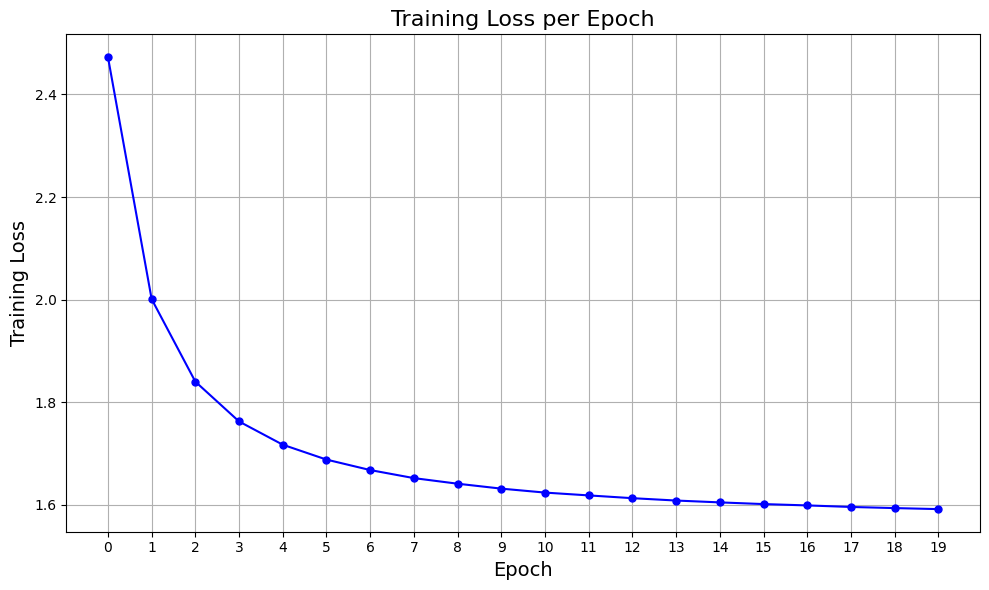

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss, marker='o', linestyle='-', color='b', markersize=5)
plt.title('Training Loss per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.xticks(range(len(training_loss)))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Saving the model
torch.save(model.state_dict(), '/kaggle/working/model.pth')

In [ ]:
vocab = dataset.vocab
word_to_idx = {w:i for w,i in vocab.items()}
idx_to_word = {i:w for w,i in vocab.items()}
embedding_dim = 100

# Loading the model
model = SkipGramHybrid(len(vocab), embedding_dim).to(device)
model.load_state_dict(torch.load('/kaggle/input/skipgram_model.pth', map_location=device))

Building vocabulary...
Creating negative sampling table...


/tmp/ipykernel_36/394975449.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/skipgram_model.pth', map_location=device))


<All keys matched successfully>

## **Task-7.** Test Analogies

In [ ]:
def get_word_vector(word, word_to_idx, embeddings):
    """Get the embedding vector for a word"""
    if word in word_to_idx:
        idx = word_to_idx[word]
        # Convert to tensor and get embedding
        idx_tensor = torch.tensor([idx])
        return embeddings(idx_tensor).detach()
    return None

def cosine_similarity_torch(v1, v2):
    """Calculate cosine similarity between two vectors using PyTorch"""
    return F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0))

def find_closest_word(vector, word_to_idx, idx_to_word, embeddings, exclude_words=None):
    """Find the word with the closest embedding to the given vector"""
    if exclude_words is None:
        exclude_words = set()

    # Create tensor of all word indices
    all_indices = torch.tensor(list(word_to_idx.values()))

    # Get embeddings for all words
    all_embeddings = embeddings(all_indices)

    # Calculate cosine similarities using PyTorch operations
    similarities = F.cosine_similarity(vector.unsqueeze(0), all_embeddings)

    # Convert to numpy for easier processing
    similarities = similarities.detach().squeeze()

    # Sort indices by similarity
    sorted_indices = torch.argsort(similarities, descending=True).numpy()

    # Find the closest word that's not in exclude_words
    for idx in sorted_indices:
        word = idx_to_word[idx]
        if word not in exclude_words:
            return word, similarities[idx]

    return None, None

def test_covid_analogy(word1, word2, word3, word_to_idx, idx_to_word, embeddings):
    """
    Test analogy of the form: word1 : word2 :: word3 : ?
    Returns the word that best completes the analogy
    """
    # Get word vectors
    v1 = get_word_vector(word1, word_to_idx, embeddings)
    v2 = get_word_vector(word2, word_to_idx, embeddings)
    v3 = get_word_vector(word3, word_to_idx, embeddings)

    if v1 is None or v2 is None or v3 is None:
        return None, None

    # Calculate the expected vector for word4
    # Using the formula: v4 ≈ v2 - v1 + v3
    target_vector = v2 - v1 + v3

    # Find the closest word to the target vector
    exclude_words = {word1, word2, word3}
    return find_closest_word(target_vector, word_to_idx, idx_to_word, embeddings, exclude_words)

def evaluate_covid_analogies(model, word_to_idx, idx_to_word):
    """
    Test a set of COVID-19 related analogies
    """
    print("Testing COVID-19 Related Analogies:\n")

    # Put model in eval mode
    model.eval()

    # Use the target embeddings for word vectors
    embeddings = model.target_embeddings

    # Example analogies using COVID-19 terms
    analogies = [
        ("antigen", "negative", "infection"),
        ("antibody", "immunity", "vaccination")
    ]

    with torch.no_grad():  # Disable gradient computation for inference
        for a1, a2, a3 in analogies:
            predicted_word, similarity = test_covid_analogy(
                a1, a2, a3, word_to_idx, idx_to_word, embeddings
            )

            print(f"{a1} : {a2} :: {a3} : ?")
            print(f"Predicted: {predicted_word}")
            if similarity is not None:
                print(f"Confidence (cosine similarity): {similarity:.4f}")
            print()

evaluate_covid_analogies(model, word_to_idx, idx_to_word)

Testing COVID-19 Related Analogies:

antigen : negative :: infection : ?
Predicted: vaccine
Confidence (cosine similarity): 0.2898

antibody : immunity :: vaccination : ?
Predicted: proteolysis
Confidence (cosine similarity): 0.3224



## Assigment-5

In [ ]:
def get_similar_words_win(word, word_to_idx, idx_to_word, model, top_k=5):
    """Find similar words using input embeddings (Win)"""
    if word not in word_to_idx:
        return []

    with torch.no_grad():
        # Get the word embedding from Win (target_embeddings)
        word_idx = torch.tensor([word_to_idx[word]])
        word_vec = model.target_embeddings(word_idx)

        # Get all word embeddings
        all_indices = torch.arange(len(word_to_idx))
        all_embeddings = model.target_embeddings(all_indices)

        # Calculate cosine similarities
        similarities = F.cosine_similarity(word_vec, all_embeddings)

        # Get top-k similar words
        top_indices = torch.argsort(similarities, descending=True)[1:top_k+1]  # Skip the word itself

        results = []
        for idx in top_indices:
            similar_word = idx_to_word[idx.item()]
            similarity = similarities[idx].item()
            results.append((similar_word, similarity))

        return results

def get_similar_words_wout(word, word_to_idx, idx_to_word, model, top_k=5):
    """Find similar words using output embeddings (Wout)"""
    if word not in word_to_idx:
        return []

    with torch.no_grad():
        # Get the word vector from Wout (context_linear weights)
        word_idx = word_to_idx[word]
        word_vec = model.context_linear.weight[word_idx]

        # Get all word vectors from Wout
        all_embeddings = model.context_linear.weight

        # Calculate cosine similarities
        similarities = F.cosine_similarity(word_vec.unsqueeze(0), all_embeddings)

        # Get top-k similar words
        top_indices = torch.argsort(similarities, descending=True)[1:top_k+1]  # Skip the word itself

        results = []
        for idx in top_indices:
            similar_word = idx_to_word[idx.item()]
            similarity = similarities[idx].item()
            results.append((similar_word, similarity))

        return results

def get_similar_words_combined(word, word_to_idx, idx_to_word, model, method='average', top_k=5):
    """Find similar words using combined embeddings (Win and Wout)"""
    if word not in word_to_idx:
        return []

    with torch.no_grad():
        word_idx = word_to_idx[word]

        # Get word vectors from both matrices
        win_vec = model.target_embeddings(torch.tensor([word_idx]))
        wout_vec = model.context_linear.weight[word_idx]

        # Combine vectors based on method
        if method == 'concatenate':
            word_vec = torch.cat([win_vec.squeeze(0), wout_vec])
        else:  # average
            word_vec = (win_vec.squeeze(0) + wout_vec) / 2

        # Get combined vectors for all words
        all_win = model.target_embeddings(torch.arange(len(word_to_idx)))
        all_wout = model.context_linear.weight

        if method == 'concatenate':
            all_embeddings = torch.cat([all_win, all_wout], dim=1)
        else:  # average
            all_embeddings = (all_win + all_wout) / 2

        # Calculate cosine similarities
        similarities = F.cosine_similarity(word_vec.unsqueeze(0), all_embeddings)

        # Get top-k similar words
        top_indices = torch.argsort(similarities, descending=True)[1:top_k+1]  # Skip the word itself

        results = []
        for idx in top_indices:
            similar_word = idx_to_word[idx.item()]
            similarity = similarities[idx].item()
            results.append((similar_word, similarity))

        return results

def compare_embeddings(word, word_to_idx, idx_to_word, model, top_k=5):
    """Compare similar words using different embedding approaches"""
    print(f"\nAnalyzing similar words for: '{word}'\n")

    # Get similar words using different methods
    win_similar = get_similar_words_win(word, word_to_idx, idx_to_word, model, top_k)
    wout_similar = get_similar_words_wout(word, word_to_idx, idx_to_word, model, top_k)
    avg_similar = get_similar_words_combined(word, word_to_idx, idx_to_word, model, 'average', top_k)
    concat_similar = get_similar_words_combined(word, word_to_idx, idx_to_word, model, 'concatenate', top_k)

    # Print results
    print("Using Input Matrix (Win):")
    for word, sim in win_similar:
        print(f"{word}: {sim:.4f}")

    print("\nUsing Output Matrix (Wout):")
    for word, sim in wout_similar:
        print(f"{word}: {sim:.4f}")

    print("\nUsing Averaged Matrices:")
    for word, sim in avg_similar:
        print(f"{word}: {sim:.4f}")

    print("\nUsing Concatenated Matrices:")
    for word, sim in concat_similar:
        print(f"{word}: {sim:.4f}")

    # Analyze overlap between methods
    all_methods = {
        'Win': set(word for word, _ in win_similar),
        'Wout': set(word for word, _ in wout_similar),
        'Average': set(word for word, _ in avg_similar),
        'Concatenate': set(word for word, _ in concat_similar)
    }

    # Calculate overlap statistics
    overlap_stats = defaultdict(int)
    for method1, words1 in all_methods.items():
        for method2, words2 in all_methods.items():
            if method1 < method2:  # Avoid counting pairs twice
                overlap = len(words1.intersection(words2))
                overlap_stats[f"{method1}-{method2}"] = overlap

    print("\nOverlap Analysis:")
    for pair, count in overlap_stats.items():
        print(f"{pair}: {count} words in common")


compare_embeddings("covid", word_to_idx, idx_to_word, model, top_k=5)


Analyzing similar words for: 'covid'

Using Input Matrix (Win):
pandemic: 0.5595
espaa: 0.4838
cuidados: 0.4712
diagnstico: 0.4687
aspectos: 0.4503

Using Output Matrix (Wout):
pandemic: 0.8617
distancing: 0.8241
combating: 0.8233
resumen: 0.8226
sgrna: 0.8203

Using Averaged Matrices:
pandemic: 0.6705
moderatetosevere: 0.5911
resumen: 0.5892
espaa: 0.5829
amid: 0.5776

Using Concatenated Matrices:
pandemic: 0.7288
diagnstico: 0.6683
espaa: 0.6668
resumen: 0.6602
cuidados: 0.6563

Overlap Analysis:
Win-Wout: 1 words in common
Average-Win: 2 words in common
Average-Wout: 2 words in common
Average-Concatenate: 3 words in common
Concatenate-Win: 4 words in common
Concatenate-Wout: 2 words in common


**Description of the outcome**

This output compares different word embedding methods by looking at their top-5 similar word predictions, measuring how many words they share in common:

1. `Win-Wout`: Only 1/5 words overlap (20%) - these methods produce quite different results
2. `Average-Win` and `Average-Wout`: Both share 2/5 words (40%) - suggesting the Average method has moderate alignment with both approaches
3. `Average-Concatenate`: 3/5 words in common (60%) - shows strong agreement between these methods
4. `Concatenate-Win`: Highest overlap with 4/5 words (80%) - indicates these two methods are finding almost the same set of similar words
5. `Concatenate-Wout`: 2/5 words in common (40%) - moderate overlap

Looking at the percentages makes the relationships clearer:
- Concatenate and Win methods are most similar (80% overlap)
- Average and Concatenate show strong agreement (60% overlap)
- Win and Wout are most different (20% overlap)
- Other combinations show moderate agreement (40% overlap)

This suggests that the Concatenate method might be capturing the best of both Win and Wout approaches, as it shows strong alignment with Win while maintaining some similarity with Wout.

**Task-5.** A slide related to the complexities of skipgram and CBOW model was shown in the class. Check if they
are correct. If not, what are the correct entries?

I can confirm that the complexities shown in the slide are correct:

1. Skip-gram with Hierarchical Softmax: O(T·N·C·log V)
- This is correct as the hierarchical softmax reduces the complexity from O(V) to O(log V)

2. Skip-gram with Negative Sampling: O(T·N·C·k)
- This is correct as negative sampling reduces complexity to depend on k samples instead of V

3. CBOW (Continuous Bag of Words) with Hierarchical Softmax: O(T·N·C·log V)
- This matches the expected complexity, similar to Skip-gram with hierarchical softmax

4. CBOW with Negative Sampling: O(T·N·C·k)
- This is accurate, following the same pattern as Skip-gram with negative sampling

5. Cosine Similarity: O(N)
- This is correct as it involves vector operations proportional to embedding dimension

6. Analogy Task: O(V·N)
- This is accurate as it typically involves scanning through the vocabulary while doing vector operations

The definitions of variables are also correctly stated:
- T: total number of words in corpus
- V: vocabulary size
- N: embedding size
- C: context window size
- k: number of negative samples